<a href="https://colab.research.google.com/github/oranginc/haneda/blob/main/haneda_int.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install playwright pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 MB 8.2 MB/s eta 0:00:00


In [ ]:
!playwright install chromium

161.3 MiB [] 0% 0.0s161.3 MiB [] 0% 55.6s161.3 MiB [] 0% 115.8s161.3 MiB [] 0% 86.9s161.3 MiB [] 0% 60.2s161.3 MiB [] 0% 48.8s161.3 MiB [] 0% 48.1s161.3 MiB [] 0% 38.5s161.3 MiB [] 0% 29.6s161.3 MiB [] 0% 31.6s161.3 MiB [] 0% 30.2s161.3 MiB [] 0% 29.0s161.3 MiB [] 0% 28.4s161.3 MiB [] 1% 26.5s161.3 MiB [] 1% 23.4s161.3 MiB [] 1% 21.7s161.3 MiB [] 1% 21.6s161.3 MiB [] 1% 21.3s161.3 MiB [] 1% 21.0s161.3 MiB [] 1% 20.7s161.3 MiB [] 2% 20.6s161.3 MiB [] 2% 21.0s161.3 MiB [] 2% 20.3s161.3 MiB [] 2% 19.9s161.3 MiB [] 2% 19.7s161.3 MiB [] 2% 19.2s161.3 MiB [] 3% 17.6s161.3 MiB [] 3% 15.1s161.3 MiB [] 3% 14.3s161.3 MiB [] 4% 13.9s161.3 MiB [] 4% 12.7s161.3 MiB [] 4% 12.0s161.3 MiB [] 5% 11.9s161.3 MiB [] 5% 11.6s161.3 MiB [] 5% 11.5s161.3 MiB [] 6% 11.3s161.3 MiB [] 6% 11.2s161.3 MiB [] 6% 11.3s161.3 MiB [] 6% 11.5s161.3 MiB [] 6% 11.6s161.3 MiB [] 7% 11.7s161.3 MiB [] 7% 11.8s161.3 MiB [] 7% 11.3s161.3 MiB [] 8% 10.6s161.3 MiB [] 9% 9.8s161.3 MiB [] 9% 9.5s161.3 MiB [] 10% 9.1s161.3 MiB [] 10

In [ ]:
!pip install nest_asyncio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 3.6 MB/s eta 0:00:00


データを haneda_flights_20250116_090327.html に保存しました


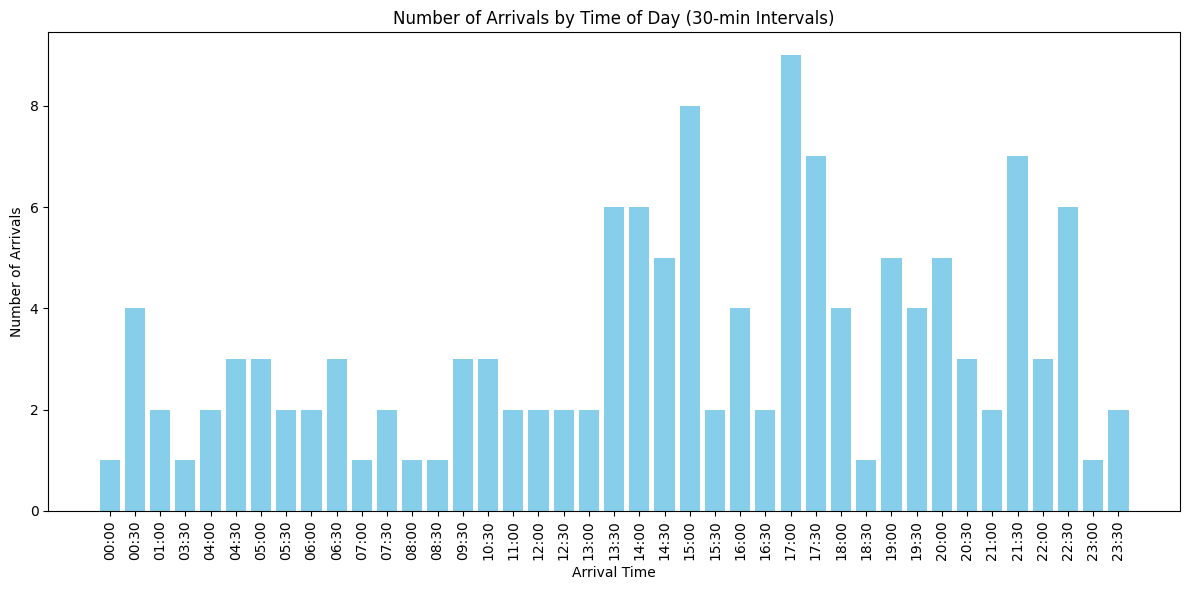

データを haneda_flights_20250116_090328.csv に保存しました


,status,scheduledTime,changedTime,airport,terminal,gate
2,到着済み,04:53,ロサンゼルス,,78E,T2
1,到着済み,05:13,ニューヨーク（JFK),,77N,T2
3,到着済み,05:18,シンガポール,,78I,T2
4,到着済み,06:10,バンコク（BKK）,,780,T2
5,到着済み,06:40,ジャカルタ,,788,T2
0,到着済み,06:45,シドニー,,78I,T2
6,到着済み,07:31,ミュンヘン,,78I,T2
7,到着済み,09:38,ソウル（金浦）,,788,T2
8,到着済み,11:56,上海（浦東）,,76E,T2
9,到着済み,15:55,パリ（CDG）,,78I,T2


T2のフライト:


In [ ]:
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from playwright.async_api import async_playwright
import asyncio


class HanedaFlightScraper:
    def __init__(self):
        self.url = "https://tokyo-haneda.com/flight/flightInfo_int.html"

    async def __aenter__(self):
        self.playwright = await async_playwright().start()
        self.browser = await self.playwright.chromium.launch(headless=True)
        self.page = await self.browser.new_page()
        return self

    async def __aexit__(self, exc_type, exc_val, exc_tb):
        await self.browser.close()
        await self.playwright.stop()

    async def setup_page(self):
        """ページの初期設定を行う"""
        await self.page.goto(self.url)
        await self.page.wait_for_load_state('networkidle')
        await self.page.wait_for_selector('.flight-timeTable-timeZone')

    async def select_all_flights(self):
        """全便表示を選択"""
        try:
            await self.page.locator("input[value='int-arrival']").check()
            await self.page.wait_for_load_state('networkidle')
            await asyncio.sleep(2)
            await self.page.select_option('.flight-timeTable-timeZone.select', value='全便を見る')
            await self.page.wait_for_load_state('networkidle')
            await asyncio.sleep(2)
        except Exception as e:
            print(f"全便表示の選択中にエラーが発生: {str(e)}")

    async def get_flight_data(self):
        """フライト情報を取得"""
        try:
            flights = await self.page.evaluate("""() => {
                const rows = document.querySelectorAll('.flight-timeTable-pc tr');
                return Array.from(rows).map(row => {
                    const cells = row.querySelectorAll('td');
                    return {
                    status: cells[0] ? cells[0].textContent.trim() : '',
                    scheduledTime: cells[1] ? cells[1].textContent.trim() : '',
                    changedTime: cells[2] ? cells[2].textContent.trim() : '',
                    airport: cells[3] ? cells[3].textContent.trim() : '',
                    terminal: cells[6] ? cells[6].textContent.trim() : '',
                    gate: cells[7] ? cells[7].textContent.trim() : ''
                    };
                });
            }""")
            # フライトデータから有効な時刻のみを返す
            # フライトデータをターミナルで分けて返す
            other_flights = [self.format_flight_time(flight) for flight in flights if flight['scheduledTime'] and flight['gate'] != 'T2']
            t2_flights = [self.format_flight_time(flight) for flight in flights if flight['scheduledTime'] and flight['gate'] == 'T2']
            return other_flights, t2_flights

            return [self.format_flight_time(flight) for flight in flights if flight['scheduledTime']]
        except Exception as e:
            print(f"フライトデータの取得中にエラーが発生: {str(e)}")
            return []

    def format_flight_time(self, flight):
        """フライトの到着時刻をフォーマット"""
        time_pattern = r"(\d{2}:\d{2})(?:\[(\d{2}:\d{2}| - )\])?"  # パターンを修正
        match = re.match(time_pattern, flight['scheduledTime'])

        if match:
            if match.group(2) and match.group(2) != ' - ':  # 条件を追加
                flight['scheduledTime'] = match.group(2)  # [HH:MM] 部分を採用
            else:
                flight['scheduledTime'] = match.group(1)  # HH:MM 部分を採用
        else:
            flight['scheduledTime'] = None

        return flight

    def count_arrivals_by_time(self, flight_data):
        """到着便数を30分ごとにカウント"""
        arrival_counts = defaultdict(int)
        for flight in flight_data:
            # 無効な時刻はスキップ
            if flight['scheduledTime']:
                rounded_time = self.round_to_nearest_half_hour(flight['scheduledTime'])
                arrival_counts[rounded_time] += 1
        return dict(arrival_counts)

    def round_to_nearest_half_hour(self, time_str):
      """時刻を30分単位に丸める"""
      hour, minute = map(int, time_str.split(":"))
      if minute < 30:
          rounded_time = f"{hour:02}:00"
      else:
          rounded_time = f"{hour:02}:30"
      return rounded_time  # 丸めた時刻を返す

    async def plot_arrivals_by_time(self, flight_data):
        """到着便数を30分ごとにプロット"""
        # 到着便数をカウント
        arrival_counts = self.count_arrivals_by_time(flight_data)

        # arrival_counts を時間でソート
        sorted_arrival_counts = dict(sorted(arrival_counts.items(), key=lambda item: datetime.strptime(item[0], '%H:%M')))


        # グラフの描画
        plt.figure(figsize=(12, 6))
        plt.bar(sorted_arrival_counts.keys(), sorted_arrival_counts.values(), color='skyblue')
        plt.xlabel('Arrival Time')
        plt.ylabel('Number of Arrivals')
        plt.title('Number of Arrivals by Time of Day (30-min Intervals)')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()



    async def save_to_csv(self, data, filename=None):
        """データをCSVファイルとして保存"""
        if not filename:
            current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
            filename = f'haneda_flights_{current_time}.csv'

       # 空白行を削除
        data = [row for row in data if any(field.strip() for field in row.values() if isinstance(field, str))]

        df = pd.DataFrame(data)
        df.to_csv(filename, index=False, encoding='utf-8-sig')
        print(f"データを {filename} に保存しました")

    async def save_to_html(self, other_flights, t2_flights):

        current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f'haneda_flights_{current_time}.html'

        # DataFrameの作成と空白行の削除
        df_other = pd.DataFrame(other_flights)
        df_t2 = pd.DataFrame(t2_flights)

        # 全ての列が空白またはNaNの行を削除
        df_other = df_other.replace('', pd.NA)
        df_t2 = df_t2.replace('', pd.NA)

        # 空白行の削除
        df_other = df_other.dropna(how='all').reset_index(drop=True)
        df_t2 = df_t2.dropna(how='all').reset_index(drop=True)

        # 特定の列が空白の行を削除
        df_other = df_other[df_other['scheduledTime'].notna()]
        df_t2 = df_t2[df_t2['scheduledTime'].notna()]

        # scheduledTimeでソート
        df_other = df_other.sort_values('scheduledTime').reset_index(drop=True)
        df_t2 = df_t2.sort_values('scheduledTime').reset_index(drop=True)

        # グラフの生成と保存
        plt.figure(figsize=(12, 6))
        arrival_counts = self.count_arrivals_by_time(other_flights)
        sorted_arrival_counts = dict(sorted(arrival_counts.items(),
                                  key=lambda item: datetime.strptime(item[0], '%H:%M')))
        plt.bar(sorted_arrival_counts.keys(), sorted_arrival_counts.values(), color='skyblue')
        plt.xlabel('Arrival Time')
        plt.ylabel('Number of Arrivals')
        plt.title('Number of Arrivals by Time of Day (30-min Intervals)')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig('flight_graph.png')
        plt.close()

        # HTMLの生成
        html_content = f"""
        <html>
        <head>
            <meta charset="utf-8">
            <title>Haneda Flight Information</title>
            <style>
                table {{ border-collapse: collapse; width: 100%; margin: 20px 0; }}
                th, td {{ border: 1px solid black; padding: 8px; text-align: center; }}
                th {{ background-color: #f2f2f2; }}
                h2 {{ color: #333; }}
                .container {{ max-width: 1200px; margin: 0 auto; padding: 20px; }}
            </style>
        </head>
        <body>
            <div class="container">
                <h2>Other Terminal Flights</h2>
                {df_other.to_html(index=False)}

                <h2>Terminal 2 Flights</h2>
                {df_t2.to_html(index=False)}

                <h2>Arrival Distribution</h2>
                <img src="flight_graph.png" alt="Flight Arrival Distribution">
            </div>
        </body>
        </html>
        """

        with open(filename, 'w', encoding='utf-8') as f:
            f.write(html_content)

        print(f"データを {filename} に保存しました")

async def main():
    async with HanedaFlightScraper() as scraper:
        try:
            # 初期設定
            await scraper.setup_page()

            # 全便表示を選択
            await scraper.select_all_flights()

            # フライトデータを取得
            other_flights, t2_flights = await scraper.get_flight_data()

            # HTMLファイルに保存
            await scraper.save_to_html(other_flights, t2_flights)

            # 到着便数を30分ごとの時間帯でグラフ表示
            await scraper.plot_arrivals_by_time(other_flights)

            # CSVに保存
            await scraper.save_to_csv(other_flights)

            # T2のフライトをテーブル表示
            if t2_flights:
                df_t2 = pd.DataFrame(t2_flights)
                # scheduledTime でソート
                df_t2 = df_t2.sort_values(by=['scheduledTime'], key=lambda col: pd.to_datetime(col, format='%H:%M', errors='coerce'))
                display(df_t2)
                print("T2のフライト:")

        except Exception as e:
            print(f"処理中にエラーが発生: {str(e)}")

if __name__ == "__main__":
    import sys
    if 'ipykernel' in sys.modules:
        import nest_asyncio
        nest_asyncio.apply()
    asyncio.run(main())
